In [2]:
import os
import pickle
import datetime
import re
import html
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from fileStreams import getFileJsonStream
from collections import defaultdict
import glob
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import logging
import random

# For NLP processing and modeling
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [14]:
# Initialize global resources once
STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()

# POS tag cache to avoid redundant tagging
POS_CACHE = {}
# Lemma cache to avoid redundant lemmatization
LEMMA_CACHE = {}

def get_wordnet_pos(tag):
    """Convert NLTK POS tag to WordNet POS tag"""
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default as noun

def preprocess_text(text, lemmatize=True, without_stopwords=True):
    """Preprocess Reddit text content with optimized NLTK operations"""
    # Handle HTML entities
    text = html.unescape(text)
    
    # Unicode normalization
    text = unicodedata.normalize('NFKD', text)
    
    # Remove URLs and Markdown formatting
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
    text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)
    text = re.sub(r'\*(.*?)\*', r'\1', text)
    
    # Remove subreddit and user references
    text = re.sub(r'/r/\w+', '', text)
    text = re.sub(r'r/\w+', '', text)
    text = re.sub(r'/u/\w+', '', text)
    text = re.sub(r'u/\w+', '', text)
    
    # Basic text cleaning
    text = re.sub("[^A-Za-z]+", ' ', text).lower()
    
    words = text.split()
    if not words:
        return []
    
    # Lemmatization first
    if lemmatize:
        # POS tagging (with cache)
        uncached_words = [w for w in words if w not in POS_CACHE]
        if uncached_words:
            tagged_uncached = nltk.pos_tag(uncached_words)
            for word, tag in tagged_uncached:
                POS_CACHE[word] = tag
        processed_words = []
        for word in words:
            tag = POS_CACHE[word]
            wordnet_pos = get_wordnet_pos(tag)
            lemma_key = (word, wordnet_pos)
            if lemma_key in LEMMA_CACHE:
                lemma = LEMMA_CACHE[lemma_key]
            else:
                lemma = LEMMATIZER.lemmatize(word, pos=wordnet_pos)
                LEMMA_CACHE[lemma_key] = lemma
            processed_words.append(lemma)
    else:
        processed_words = words

    # Remove stopwords after lemmatization
    if without_stopwords:
        processed_words = [w for w in processed_words if w not in STOP_WORDS]

    # Remove all words with length <= 2
    processed_words = [w for w in processed_words if len(w) > 2]

    return processed_words


def process_and_save_comments(path, subreddit, output_dir, without_stopwords=True, batch_size=1000000):
    """Process comments and save in batches"""
    print(f"Processing file: {path}")
    
    # Batch processing counters
    batch_count = 0
    batch_number = 1
    total_count = 0
    
    # Create data structure for comments
    comments_batch = []

    with open(path, "rb") as f:
        jsonStream = getFileJsonStream(path, f)
        if jsonStream is None:
            print(f"Unable to read file {path}")
            return
        
        for row in tqdm(jsonStream, desc=f"Processing {subreddit} comments"):
            if "body" not in row or "created_utc" not in row or "author" not in row or "id" not in row:
                continue
                
            author = row["author"]
            if author in {"AutoModerator", "election_info_bot"}:
                continue
            
            comment_id = row["id"]
            text = row["body"]
            created_timestamp = row["created_utc"]
            date = datetime.datetime.fromtimestamp(int(created_timestamp))
            
            # Process text with optimized functions
            processed_words = preprocess_text(text, lemmatize=True, without_stopwords=without_stopwords)
            
            if processed_words:
                # Save processed comment with metadata
                comment_data = {
                    "comment_id": comment_id,
                    "author": author,
                    "date": date.strftime("%Y-%m-%d"),
                    "timestamp": created_timestamp,
                    "processed_text": processed_words,  # Original order preserved
                    "original": text
                }
                
                comments_batch.append(comment_data)
                batch_count += 1
                
            # Check if we need to save the current batch
            if batch_count >= batch_size:
                print(f"\nReached {batch_size} comments, saving batch {batch_number}...")
                
                # Save batch directly without filtering
                save_path = f"{output_dir}/{subreddit}_batch{batch_number}.pkl"
                with open(save_path, "wb") as out_file:
                    pickle.dump(comments_batch, out_file)
                
                print(f"Saved {len(comments_batch)} comments to {save_path}")
                
                # Reset batch data
                comments_batch = []
                batch_count = 0
                batch_number += 1
                total_count += batch_size
    
    # Process any remaining comments
    if batch_count > 0:
        print(f"\nSaving remaining {batch_count} comments...")
        
        # Save batch
        save_path = f"{output_dir}/{subreddit}_batch{batch_number}.pkl"
        with open(save_path, "wb") as out_file:
            pickle.dump(comments_batch, out_file)
        
        print(f"Saved {len(comments_batch)} comments to {save_path}")
        total_count += batch_count
    
    print(f"\nCompleted processing {subreddit} comments!")
    print(f"Total comments saved: {total_count}")


def main():
    """Main function"""
    random.seed(23)
    np.random.seed(23)
    
    # Define data file paths
    files = {
        "democrats": r"datasets/democrats_comments.zst",
        "republican": r"datasets/Republican_comments.zst",
        "conservative": r"datasets/Conservative_comments.zst",
        "liberal": r"datasets/Liberal_comments.zst",
        "vagabond": r"datasets/vagabond_comments.zst",
        "backpacking": r"datasets/backpacking_comments.zst"
    }
    
    # List of subreddits to process (process all by default)
    subreddits_to_process = list(files.keys())

    for subreddit in subreddits_to_process:
        output_dir = f"processed_comments_1/{subreddit}"
        os.makedirs(output_dir, exist_ok=True)
        print(f"\nProcessing subreddit: {subreddit}")
        process_and_save_comments(
            files[subreddit],
            subreddit,
            output_dir,
            without_stopwords=True,
            batch_size=1000000
        )

if __name__ == "__main__":
    main()


Processing subreddit: democrats
Processing file: datasets/democrats_comments.zst


Processing democrats comments: 1041009it [00:40, 29847.97it/s]


Reached 1000000 comments, saving batch 1...


Processing democrats comments: 1046732it [00:42, 5412.88it/s] 

Saved 1000000 comments to processed_comments_1/democrats/democrats_batch1.pkl


Processing democrats comments: 2011525it [01:14, 27009.24it/s]



Saving remaining 933460 comments...
Saved 933460 comments to processed_comments_1/democrats/democrats_batch2.pkl

Completed processing democrats comments!
Total comments saved: 1933460

Processing subreddit: republican
Processing file: datasets/Republican_comments.zst


Processing republican comments: 1078145it [00:42, 29803.89it/s]


Reached 1000000 comments, saving batch 1...
Saved 1000000 comments to processed_comments_1/republican/republican_batch1.pkl


Processing republican comments: 1405486it [00:56, 24786.15it/s]



Saving remaining 291012 comments...
Saved 291012 comments to processed_comments_1/republican/republican_batch2.pkl

Completed processing republican comments!
Total comments saved: 1291012

Processing subreddit: conservative
Processing file: datasets/Conservative_comments.zst


Processing conservative comments: 1011866it [00:44, 17799.47it/s]


Reached 1000000 comments, saving batch 1...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch1.pkl


Processing conservative comments: 2025839it [01:28, 28877.03it/s]


Reached 1000000 comments, saving batch 2...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch2.pkl


Processing conservative comments: 3036621it [02:10, 31048.85it/s]


Reached 1000000 comments, saving batch 3...


Processing conservative comments: 3039744it [02:12, 3751.51it/s] 

Saved 1000000 comments to processed_comments_1/conservative/conservative_batch3.pkl


Processing conservative comments: 4049101it [02:51, 25520.91it/s]


Reached 1000000 comments, saving batch 4...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch4.pkl


Processing conservative comments: 5058595it [03:35, 24280.19it/s]


Reached 1000000 comments, saving batch 5...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch5.pkl


Processing conservative comments: 6074933it [04:19, 32338.80it/s]


Reached 1000000 comments, saving batch 6...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch6.pkl


Processing conservative comments: 7090695it [04:59, 45364.87it/s]


Reached 1000000 comments, saving batch 7...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch7.pkl


Processing conservative comments: 8100760it [05:37, 28816.36it/s]


Reached 1000000 comments, saving batch 8...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch8.pkl


Processing conservative comments: 9112254it [06:15, 31423.98it/s]


Reached 1000000 comments, saving batch 9...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch9.pkl


Processing conservative comments: 10125596it [06:54, 27540.54it/s]


Reached 1000000 comments, saving batch 10...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch10.pkl


Processing conservative comments: 11140660it [07:34, 32530.57it/s]


Reached 1000000 comments, saving batch 11...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch11.pkl


Processing conservative comments: 12150447it [08:12, 29498.95it/s]


Reached 1000000 comments, saving batch 12...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch12.pkl


Processing conservative comments: 13160237it [08:54, 31940.30it/s]


Reached 1000000 comments, saving batch 13...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch13.pkl


Processing conservative comments: 14166960it [09:30, 38111.65it/s]


Reached 1000000 comments, saving batch 14...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch14.pkl


Processing conservative comments: 15179384it [10:05, 35041.33it/s]


Reached 1000000 comments, saving batch 15...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch15.pkl


Processing conservative comments: 16187065it [10:41, 35832.38it/s]


Reached 1000000 comments, saving batch 16...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch16.pkl


Processing conservative comments: 17194551it [11:16, 38422.92it/s]


Reached 1000000 comments, saving batch 17...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch17.pkl


Processing conservative comments: 18203648it [11:47, 39290.38it/s]


Reached 1000000 comments, saving batch 18...
Saved 1000000 comments to processed_comments_1/conservative/conservative_batch18.pkl


Processing conservative comments: 18984143it [12:11, 25961.33it/s]



Saving remaining 773068 comments...
Saved 773068 comments to processed_comments_1/conservative/conservative_batch19.pkl

Completed processing conservative comments!
Total comments saved: 18773068

Processing subreddit: liberal
Processing file: datasets/Liberal_comments.zst


Processing liberal comments: 497079it [00:20, 23936.50it/s]



Saving remaining 490206 comments...
Saved 490206 comments to processed_comments_1/liberal/liberal_batch1.pkl

Completed processing liberal comments!
Total comments saved: 490206

Processing subreddit: vagabond
Processing file: datasets/vagabond_comments.zst


Processing vagabond comments: 513168it [00:21, 24000.93it/s]



Saving remaining 487176 comments...
Saved 487176 comments to processed_comments_1/vagabond/vagabond_batch1.pkl

Completed processing vagabond comments!
Total comments saved: 487176

Processing subreddit: backpacking
Processing file: datasets/backpacking_comments.zst


Processing backpacking comments: 866545it [00:39, 22202.20it/s]



Saving remaining 813611 comments...
Saved 813611 comments to processed_comments_1/backpacking/backpacking_batch1.pkl

Completed processing backpacking comments!
Total comments saved: 813611


In [3]:
def get_date_from_comment(comment):
    """Extract date from a comment dictionary"""
    try:
        return datetime.datetime.strptime(comment["date"], "%Y-%m-%d").date()
    except (KeyError, ValueError):
        try:
            return datetime.datetime.fromtimestamp(int(comment["timestamp"])).date()
        except (KeyError, ValueError):
            return None

def get_period(date):
    """Determine which time period a date belongs to"""
    if date is None:
        return None
    year = date.year
    if year <= 2016:
        return "before_2016"
    elif 2017 <= year <= 2020:
        return "2017_2020"
    elif 2021 <= year <= 2024:
        return "2021_2024"
    return None

def build_bigram_model(comments, min_count=5):
    """Build a bigram model for the given comments"""
    sentences = []
    for comment in comments:
        if "processed_text" in comment:
            sentences.append(comment["processed_text"])
    phrases = Phrases(sentences, min_count=min_count, threshold=10)
    return Phraser(phrases)

def apply_bigrams(comments, bigram_model):
    """Apply bigram model to comments"""
    processed = []
    for comment in comments:
        if "processed_text" in comment:
            processed.append(bigram_model[comment["processed_text"]])
    return processed

def create_or_update_model(period, comments, vector_size, window, min_count, workers, sg, epochs, existing_model=None):
    """Create a new model or update an existing one"""
    if existing_model is None:
        model = Word2Vec(
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=workers,
            sg=sg,
            seed=23
        )
        model.build_vocab(comments)
        print(f"{period} vocabulary size: {len(model.wv.index_to_key)}")
    else:
        model = existing_model
        model.build_vocab(comments, update=True)
        print(f"{period} vocabulary size: {len(model.wv.index_to_key)}")
    model.train(comments, total_examples=len(comments), epochs=epochs)
    return model

def save_model(model, subreddit, period, model_dir, is_interim=False):
    """Save model to disk"""
    if is_interim:
        path = f"{model_dir}/interim/{subreddit}_{period}_interim.model"
    else:
        path = f"{model_dir}/{subreddit}_{period}.model"
    model.save(path)

def build_models_for_subreddit(
    subreddit,
    base_data_dir,
    model_dir,
    vector_size=300,
    window=5,
    min_count=5,
    epochs=5,
    workers=16,
    sg=0,
    min_comments_to_train=10000,
    chunk_size=1000000
):
    time_periods = ["before_2016", "2017_2020", "2021_2024"]
    models = {period: None for period in time_periods}
    bigram_models = {period: None for period in time_periods}

    # Find all pickle files
    pattern = f"{base_data_dir}/{subreddit}/{subreddit}_batch*.pkl"
    pickle_files = sorted(glob.glob(pattern))
    if not pickle_files:
        print(f"No pickle files found for {subreddit} in {base_data_dir}/{subreddit}/")
        return

    comments_by_period = {period: [] for period in time_periods}

    for file_path in pickle_files:
        try:
            with open(file_path, 'rb') as f:
                comments = pickle.load(f)
            print(f"Loaded {len(comments)} comments from {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

        for comment in comments:
            date = get_date_from_comment(comment)
            period = get_period(date)
            if period:
                comments_by_period[period].append(comment)

        for period in time_periods:
            period_comments = comments_by_period[period]
            while len(period_comments) >= chunk_size:
                print(f"Processing chunk of {chunk_size} comments for {period}")
                chunk = period_comments[:chunk_size]
                period_comments = period_comments[chunk_size:]

                bigram_model = build_bigram_model(chunk)
                bigram_models[period] = bigram_model
                processed_chunk = apply_bigrams(chunk, bigram_model)

                if len(processed_chunk) > min_comments_to_train:
                    model = create_or_update_model(
                        period, processed_chunk, vector_size, window, min_count, workers, sg, epochs, models[period]
                    )
                    models[period] = model
                    save_model(model, subreddit, period, model_dir, is_interim=True)
            comments_by_period[period] = period_comments

    # Process any remaining comments
    for period, remaining_comments in comments_by_period.items():
        if len(remaining_comments) > min_comments_to_train:
            print(f"Processing final {len(remaining_comments)} comments for {period}")
            bigram_model = build_bigram_model(remaining_comments)
            bigram_models[period] = bigram_model
            processed_chunk = apply_bigrams(remaining_comments, bigram_model)
            model = create_or_update_model(
                period, processed_chunk, vector_size, window, min_count, workers, sg, epochs, models[period]
            )
            models[period] = model
            save_model(model, subreddit, period, model_dir, is_interim=False)
        else:
            print(f"Skipping final {len(remaining_comments)} comments for {period} (less than minimum required)")

    # Save final models
    for period, model in models.items():
        if model is not None:
            save_model(model, subreddit, period, model_dir, is_interim=False)
    print(f"Model saved to {model_dir}")
    print(f"Completed building models for {subreddit}")

def main():
    model_dir = "models/chunk_1"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(f"{model_dir}/interim", exist_ok=True)
    random.seed(23)
    np.random.seed(23)
    subreddits = ["democrats", "republican", "conservative", "liberal", "vagabond", "backpacking"]
    for subreddit in subreddits:
        build_models_for_subreddit(
            subreddit,
            base_data_dir="processed_comments_1",
            model_dir=model_dir,
            vector_size=300,
            window=5,
            min_count=5,
            epochs=5,
            workers=16,
            sg=0,
            min_comments_to_train=10000,
            chunk_size=1000000
        )

if __name__ == "__main__":
    main()

Loaded 1000000 comments from processed_comments_1/democrats\democrats_batch1.pkl
Loaded 933460 comments from processed_comments_1/democrats\democrats_batch2.pkl
Processing chunk of 1000000 comments for 2021_2024
2021_2024 vocabulary size: 50703
Processing final 127202 comments for before_2016
before_2016 vocabulary size: 21870
Processing final 472792 comments for 2017_2020
2017_2020 vocabulary size: 35551
Processing final 333466 comments for 2021_2024
2021_2024 vocabulary size: 53030
Model saved to models/chunk_1
Completed building models for democrats
Loaded 1000000 comments from processed_comments_1/republican\republican_batch1.pkl
Loaded 291012 comments from processed_comments_1/republican\republican_batch2.pkl
Processing final 263616 comments for before_2016
before_2016 vocabulary size: 32345
Processing final 414821 comments for 2017_2020
2017_2020 vocabulary size: 34603
Processing final 612575 comments for 2021_2024
2021_2024 vocabulary size: 39731
Model saved to models/chunk_1
Co


Comparing models:
before_2016: Common vocabulary between republican and democrats: 17583 words
Results saved to output/final_chunk/republican_democrats_before_2016.csv
before_2016: Common vocabulary between republican and conservative: 29205 words
Results saved to output/final_chunk/republican_conservative_before_2016.csv
before_2016: Common vocabulary between democrats and conservative: 19283 words
Results saved to output/final_chunk/democrats_conservative_before_2016.csv
2017_2020: Common vocabulary between republican and democrats: 24319 words
Results saved to output/final_chunk/republican_democrats_2017_2020.csv
2017_2020: Common vocabulary between republican and conservative: 32653 words
Results saved to output/final_chunk/republican_conservative_2017_2020.csv
2017_2020: Common vocabulary between democrats and conservative: 31554 words
Results saved to output/final_chunk/democrats_conservative_2017_2020.csv
2021_2024: Common vocabulary between republican and democrats: 29872 word

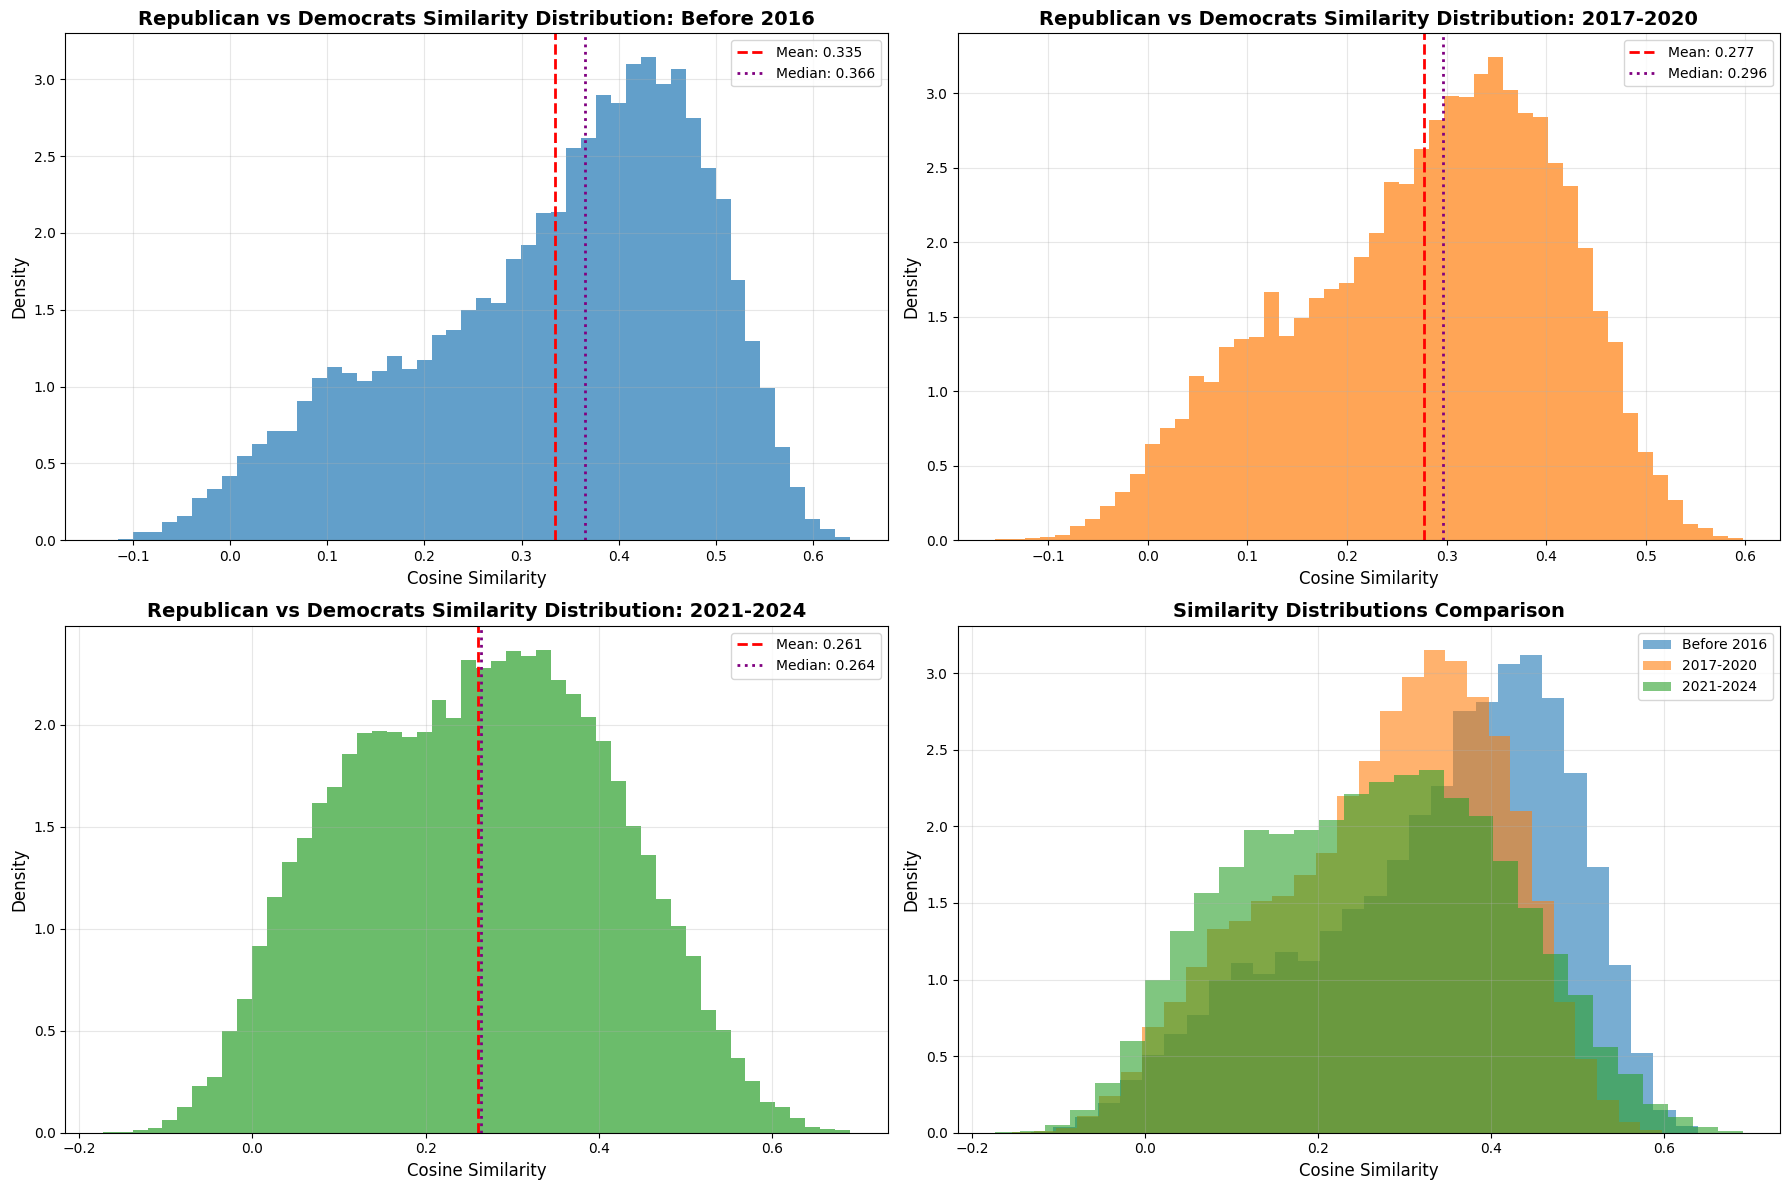

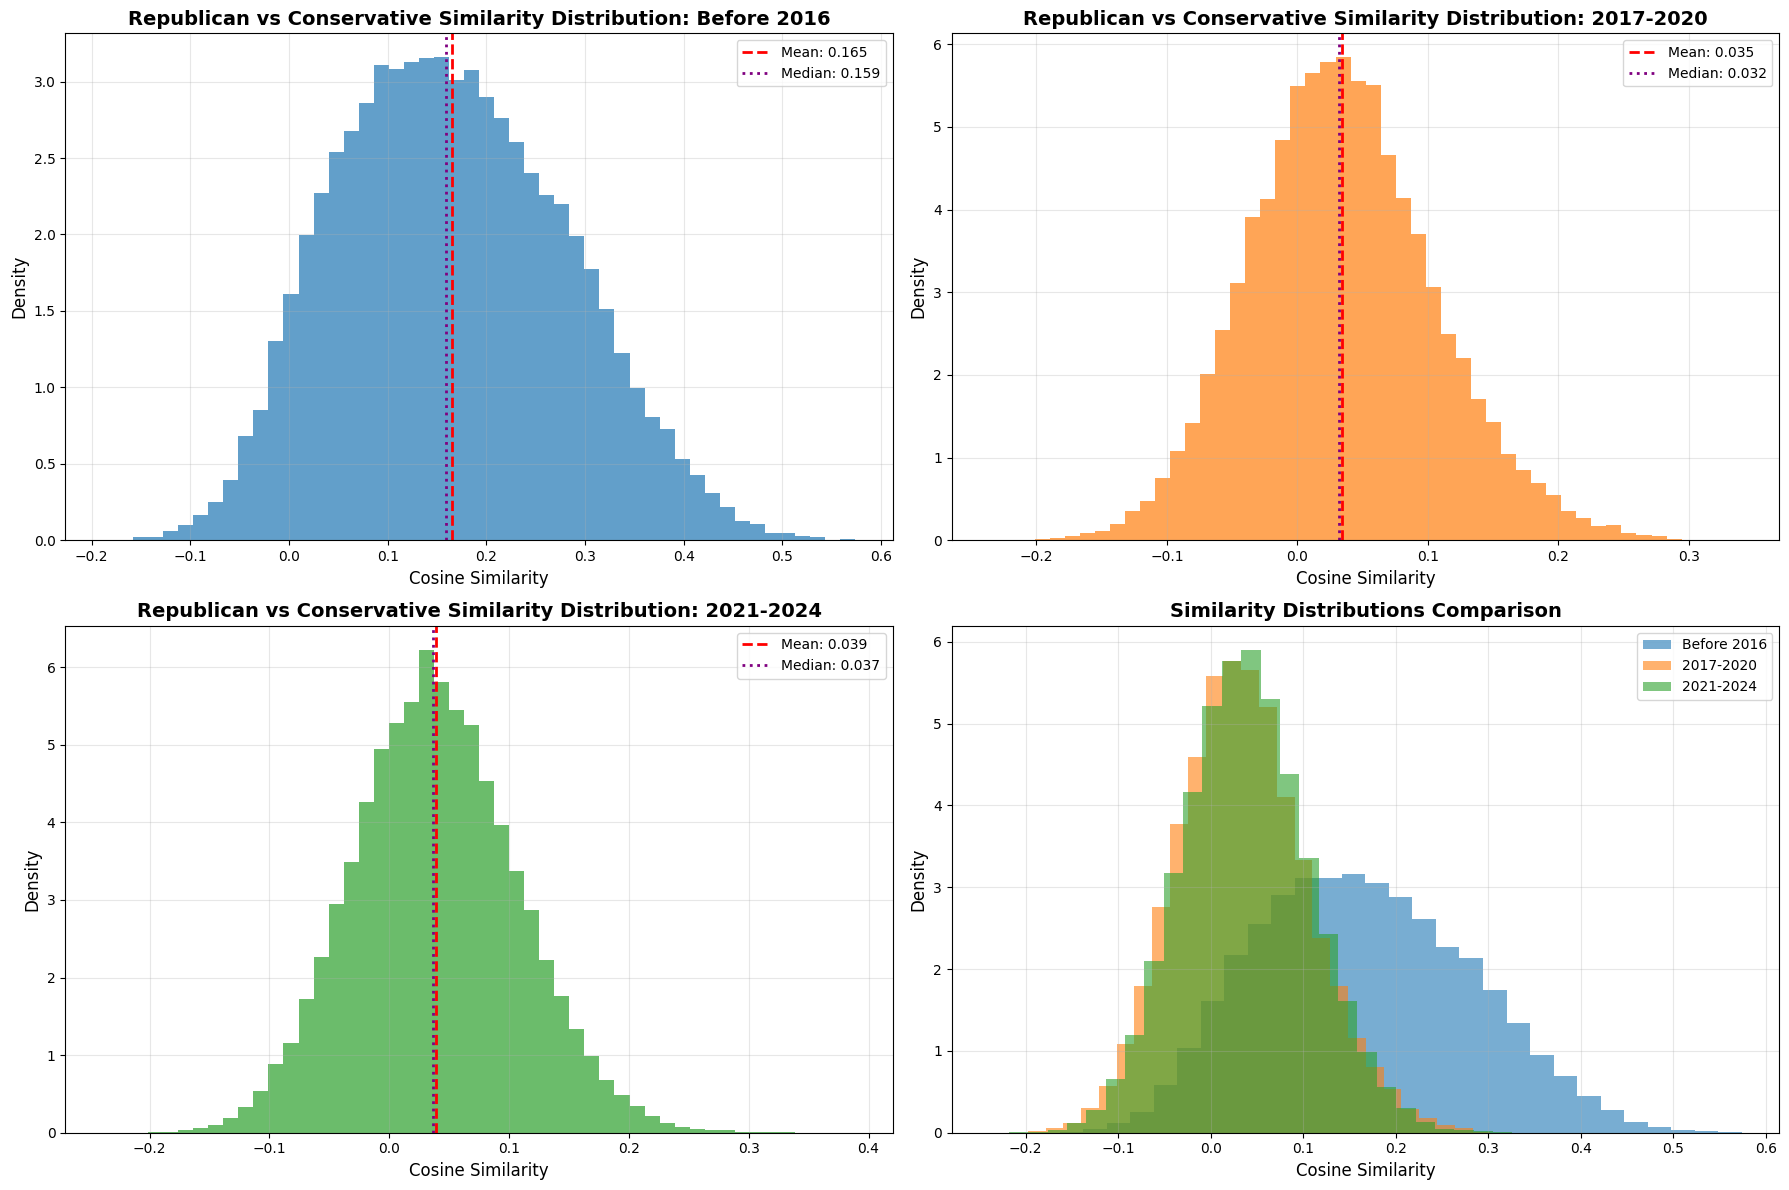

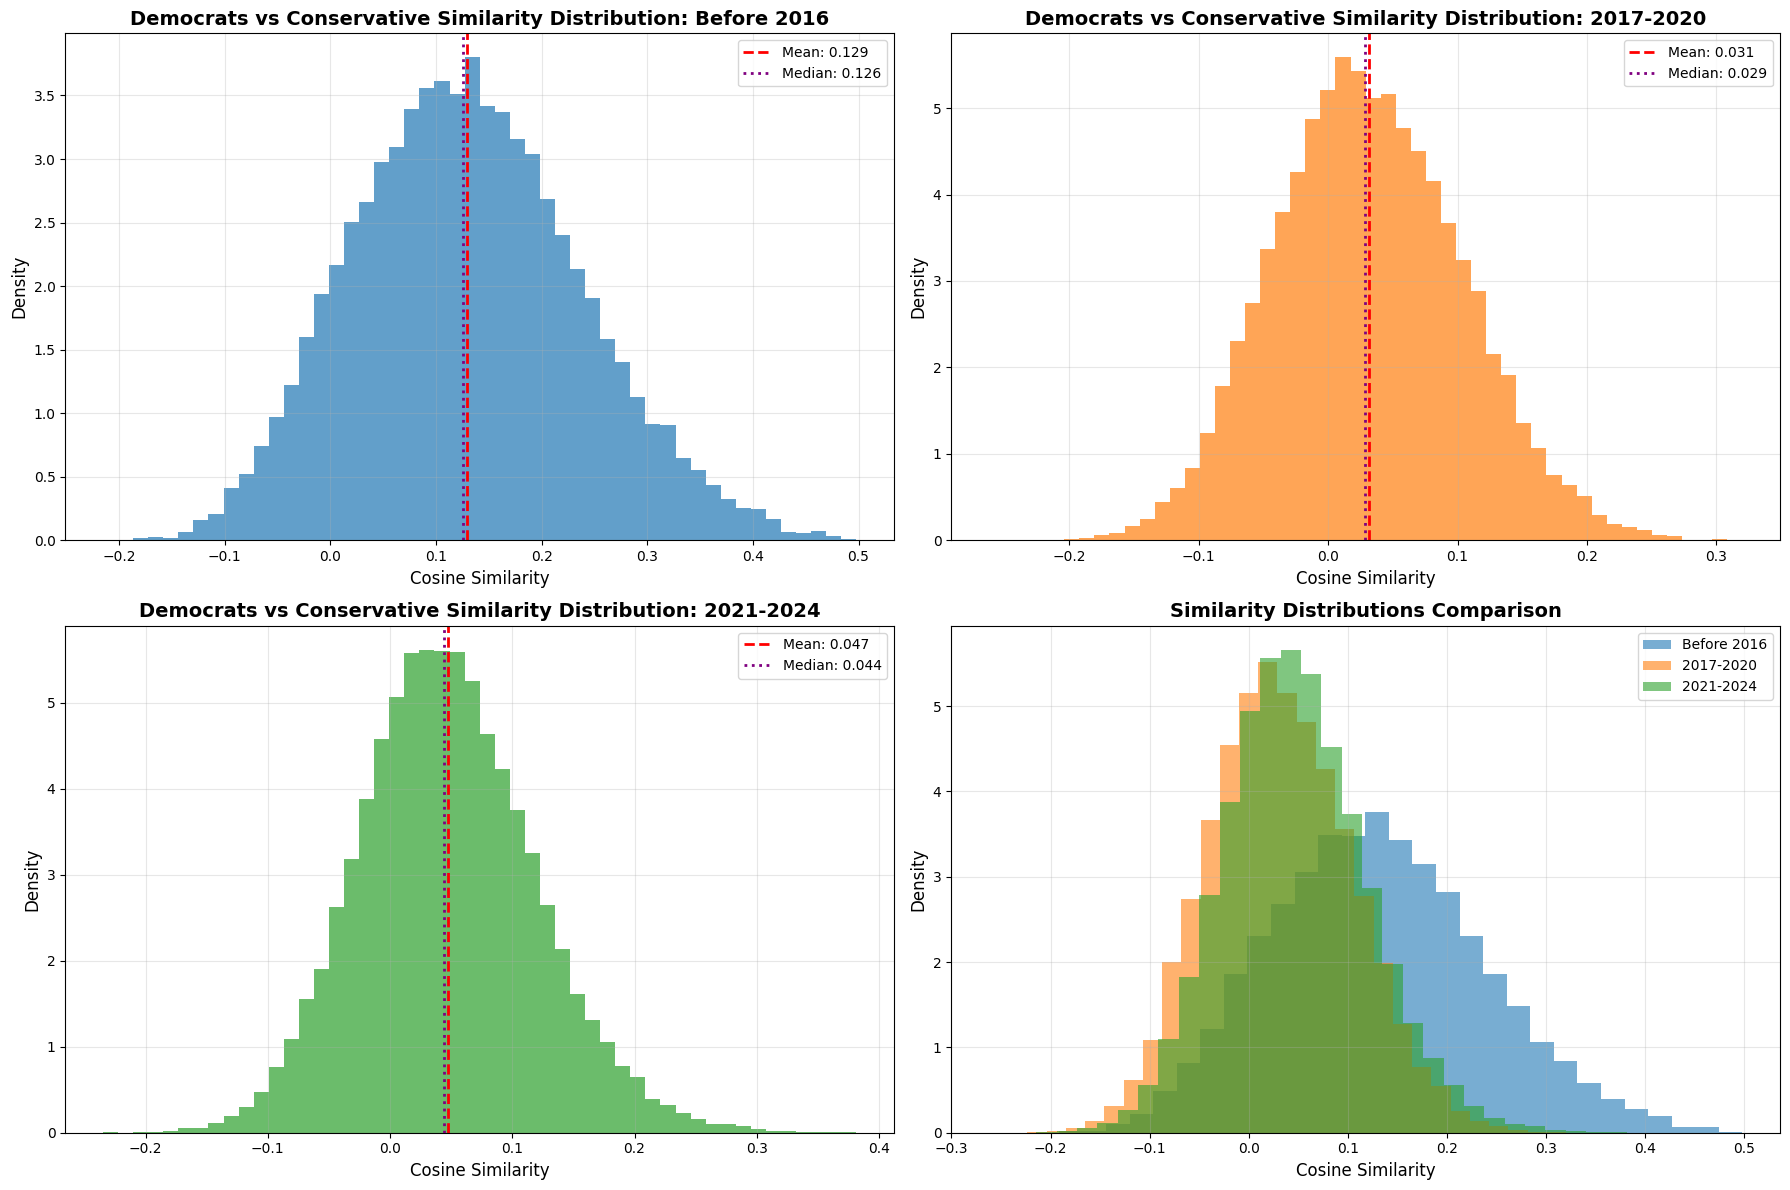

In [12]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

# Democrats vs Republicans
input_dir = "models/final_chunk"
democrats_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_before_2016.model")
democrats_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_2017_2020.model")
democrats_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_2021_2024.model")
republican_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/republican_before_2016.model")
republican_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/republican_2017_2020.model")
republican_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/republican_2021_2024.model")
conservative_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/conservative_before_2016.model")
conservative_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/conservative_2017_2020.model")
conservative_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/conservative_2021_2024.model")

# Define output directory
output_dir = "output/final_chunk"
os.makedirs(output_dir, exist_ok=True)

print("\nComparing models:")
# Before 2016

compare_subreddit_embeddings_by_period(
    republican_before_2016, 
    democrats_before_2016,
    "republican", 
    "democrats",
    "before_2016",
    output_file=f"{output_dir}/republican_democrats_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    republican_before_2016, 
    conservative_before_2016,
    "republican", 
    "conservative",
    "before_2016",
    output_file=f"{output_dir}/republican_conservative_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    democrats_before_2016, 
    conservative_before_2016,
    "democrats", 
    "conservative",
    "before_2016",
    output_file=f"{output_dir}/democrats_conservative_before_2016.csv"
)

# 2017-2020

compare_subreddit_embeddings_by_period(
    republican_2017_2020, 
    democrats_2017_2020,
    "republican", 
    "democrats",
    "2017_2020",
    output_file=f"{output_dir}/republican_democrats_2017_2020.csv"
)

compare_subreddit_embeddings_by_period(
    republican_2017_2020, 
    conservative_2017_2020,
    "republican", 
    "conservative",
    "2017_2020",
    output_file=f"{output_dir}/republican_conservative_2017_2020.csv"
)

compare_subreddit_embeddings_by_period(
    democrats_2017_2020, 
    conservative_2017_2020,
    "democrats", 
    "conservative",
    "2017_2020",
    output_file=f"{output_dir}/democrats_conservative_2017_2020.csv"
)

# 2021-2024

compare_subreddit_embeddings_by_period(
    republican_2021_2024, 
    democrats_2021_2024,
    "republican", 
    "democrats",
    "2021_2024",
    output_file=f"{output_dir}/republican_democrats_2021_2024.csv"
)

compare_subreddit_embeddings_by_period(
    republican_2021_2024, 
    conservative_2021_2024,
    "republican", 
    "conservative",
    "2021_2024",
    output_file=f"{output_dir}/republican_conservative_2021_2024.csv"
)

compare_subreddit_embeddings_by_period(
    democrats_2021_2024, 
    conservative_2021_2024,
    "democrats", 
    "conservative",
    "2021_2024",
    output_file=f"{output_dir}/democrats_conservative_2021_2024.csv"
)

print("\nAnalysis complete.")


def analyze_similarity_distributions(output_dir, df_before_2016, df_2017_2020, df_2021_2024, subreddit1, subreddit2):
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{subreddit1}_{subreddit2}_similarity_distributions.png")
    plt.show()



# Run the analysis
# Read the CSV files
republican_democrats_before_2016 = pd.read_csv(f"{output_dir}/republican_democrats_before_2016.csv")
republican_democrats_2017_2020 = pd.read_csv(f"{output_dir}/republican_democrats_2017_2020.csv")
republican_democrats_2021_2024 = pd.read_csv(f"{output_dir}/republican_democrats_2021_2024.csv")
republican_conservative_before_2016 = pd.read_csv(f"{output_dir}/republican_conservative_before_2016.csv")
republican_conservative_2017_2020 = pd.read_csv(f"{output_dir}/republican_conservative_2017_2020.csv")
republican_conservative_2021_2024 = pd.read_csv(f"{output_dir}/republican_conservative_2021_2024.csv")
democrats_conservative_before_2016 = pd.read_csv(f"{output_dir}/democrats_conservative_before_2016.csv")
democrats_conservative_2017_2020 = pd.read_csv(f"{output_dir}/democrats_conservative_2017_2020.csv")
democrats_conservative_2021_2024 = pd.read_csv(f"{output_dir}/democrats_conservative_2021_2024.csv")

analyze_similarity_distributions(
    output_dir,
    republican_democrats_before_2016, 
    republican_democrats_2017_2020, 
    republican_democrats_2021_2024, 
    "Republican", 
    "Democrats"
    )

analyze_similarity_distributions(
    output_dir,
    republican_conservative_before_2016, 
    republican_conservative_2017_2020, 
    republican_conservative_2021_2024,
    "Republican", 
    "Conservative"
    )

analyze_similarity_distributions(
    output_dir,
    democrats_conservative_before_2016, 
    democrats_conservative_2017_2020, 
    democrats_conservative_2021_2024,
    "Democrats", 
    "Conservative"
    )